# Cost Estimation Model

## Libraries

In [1]:
pip install fastexcel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 12.7 MB/s eta 0:00:00


In [2]:
pip install xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 3.0 MB/s eta 0:00:00


Side note: It will be useful to put all the required libraries in a requirements.txt file

In [4]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_score
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import make_score

## Global variables

In [5]:
# Input paths
PATH_DATAFRAME = 'full_join.xlsx'

## Global functions

We're building a cost estimation model that predicts the financial impact when packaging problems occur. This helps businesses understand potential costs and make informed decisions about packaging investments.

### 1. Read excel files with Polars

In [6]:
def polars_read_excel(file_name, sheet_name='Sheet1'):
  return pl.read_excel(source=file_name, sheet_name=sheet_name)

## Model development

### 1. File reading

We start by loading our integrated dataset which includes cost information for packaging incidents. This data will help us understand what drives packaging costs and build accurate cost predictions.

In [7]:
df = polars_read_excel(PATH_DATAFRAME)

### 2. Column type

In [8]:
df = df.with_columns([
    pl.col("CostImpact (€)").cast(pl.Float64, strict=False),
])

### 3. Data selection

We focus only on cases where packaging incidents actually occurred and have recorded cost impacts. This gives us real examples to learn from when building our cost prediction model.

In [9]:
df_input = (
    df
    .filter(pl.col("IncidentID_AutoGen").is_not_null())
    .filter(pl.col("PackagingQuality").is_in(["Bad", "Good"]))
    .sort("DateOfReport")
    .select([
        "SupplierName",
        "GarmentType",
        "Material",
        "Weight",
        "ProposedUnitsPerCarton",
        "ProposedFoldingMethod",
        "ProposedLayout",
        "Size",
        "Collection",
        "PackagingQuality",
        "IssueDescription",
        "CostImpact (€)"
    ])
)

In [26]:
df_input.head()

SupplierName,GarmentType,Material,Weight,ProposedUnitsPerCarton,ProposedFoldingMethod,ProposedLayout,Size,Collection,PackagingQuality,IssueDescription,CostImpact (€)
str,str,str,f64,i64,str,str,str,str,str,str,f64
"""SupplierA""","""Dress""","""Linen""",0.48,31,"""Method3""","""LayoutB""","""L""","""Summer""","""Good""","""Missing Items""",538.0
"""SupplierD""","""Shirt""","""Silk""",0.12,30,"""Method3""","""LayoutA""","""M""","""Spring""","""Bad""","""Incorrect Folding""",581.25
"""SupplierC""","""Dress""","""Cotton""",0.51,18,"""Method1""","""LayoutB""","""M""","""Winter""","""Bad""","""Other""",151.0
"""SupplierB""","""Shirt""","""Cotton""",0.2,24,"""Method1""","""LayoutA""","""S""","""Autumn""","""Good""","""Labeling Error""",228.0
"""SupplierA""","""Coat""","""Cotton""",1.44,7,"""Method1""","""LayoutD""","""XL""","""Summer""","""Bad""","""Packaging Damage""",1457.0


Now we create additional features that will help our model better understand cost patterns. We're adding complexity scores, seasonal indicators, and supplier rankings to capture factors that influence packaging costs.

In [28]:
# Copy original dataframe
df_fe = df_input.to_pandas().copy()

# 2. Seasonal dummies
df_fe["IsSummer"] = (df_fe["Collection"] == "Summer").astype(int)
df_fe["IsWinter"] = (df_fe["Collection"] == "Winter").astype(int)

# 3. Packing Complexity Score (example encoding)
layout_map = {"LayoutA": 1, "LayoutB": 2, "LayoutC": 3, "LayoutD": 4, "LayoutE": 5}
folding_map = {"Method1": 1, "Method2": 2, "Method3": 3}
df_fe["LayoutComplexity"] = df_fe["ProposedLayout"].map(layout_map)
df_fe["FoldingComplexity"] = df_fe["ProposedFoldingMethod"].map(folding_map)

# 4. Top 5 suppliers flag
top_suppliers = df_fe["SupplierName"].value_counts().nlargest(5).index
df_fe["SupplierIsTop5"] = df_fe["SupplierName"].isin(top_suppliers).astype(int)

# 5. Label-related issue
df_fe["LabelIssue"] = df_fe["IssueDescription"].str.contains("Label", case=False).astype(int)

# 6. Encode PackagingQuality
df_fe["PackagingQualityEncoded"] = df_fe["PackagingQuality"].map({"Good": 1, "Bad": 0})

### 4. Categorical boosting

#### 4.1 Training

We're training a specialized model that predicts the median cost impact of packaging incidents. This type of model is particularly good at handling cost data, which often has extreme values and varying ranges.

In [30]:
# --- Custom Pinball Loss Scorer (same as used by LightGBM internally) ---
def pinball_loss(y_true, y_pred, alpha=0.5):
    delta = y_true - y_pred
    return np.mean(np.maximum(alpha * delta, (alpha - 1) * delta))

# Custom scorer wrapper
alpha = 0.5  # Change this to 0.1 or 0.9 for other quantiles
pinball_scorer = make_scorer(pinball_loss, alpha=alpha, greater_is_better=False)

# --- Setup Quantile Regressor ---
model = LGBMRegressor(objective='quantile', alpha=alpha, random_state=42)

# Same param grid as before (can simplify if needed)
param_grid = {
    'num_leaves': [30, 50],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05],
    'n_estimators': [500, 1000],
    'min_child_samples': [20, 50]
}

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Grid search
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=pinball_scorer,
    cv=cv,
    verbose=2,
    n_jobs=-1
)

grid.fit(X, y)

# Output best model
print("✅ Best Pinball Loss (α = 0.5):", -grid.best_score_)
print("🧠 Best Parameters:", grid.best_params_)
best_quantile_model = grid.best_estimator_

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 315
[LightGBM] [Info] Number of data points in the train set: 16311, number of used features: 18
[LightGBM] [Info] Start training from score 553.751058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

#### 4.2 Final model evaluation

Let's test our cost prediction model to see how accurately it estimates packaging incident costs. We'll examine various metrics and charts to understand the model's performance and reliability.

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Re-split for evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit best quantile model on full training set
best_quantile_model.fit(X_train, y_train)

# Predict
y_pred = best_quantile_model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))  # RMSE still useful
r2 = r2_score(y_test, y_pred)

print("\n📊 Evaluation of Quantile Model (α = 0.5 - median):")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train set: 13048, number of used features: 18
[LightGBM] [Info] Start training from score 363.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

These charts help us understand how well our cost model performs. The scatter plot shows if predictions match actual costs, while the residual plots reveal any patterns in prediction errors.

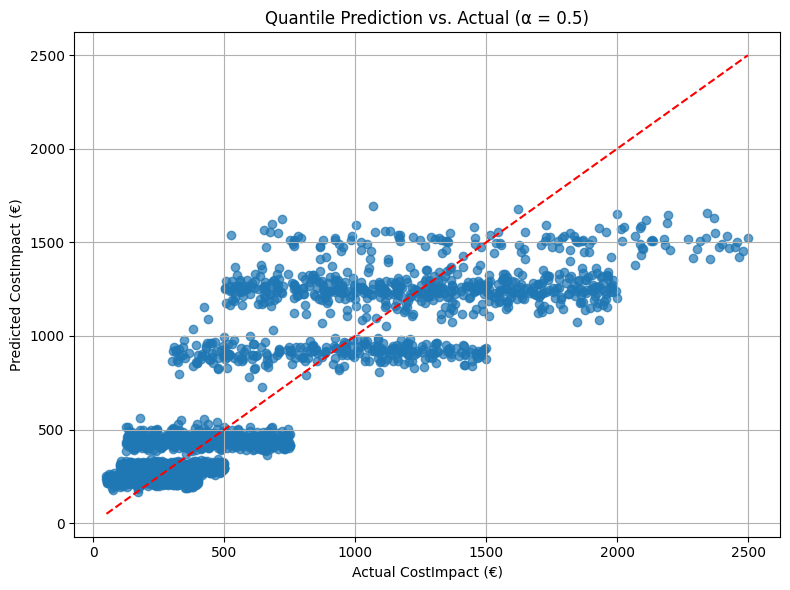

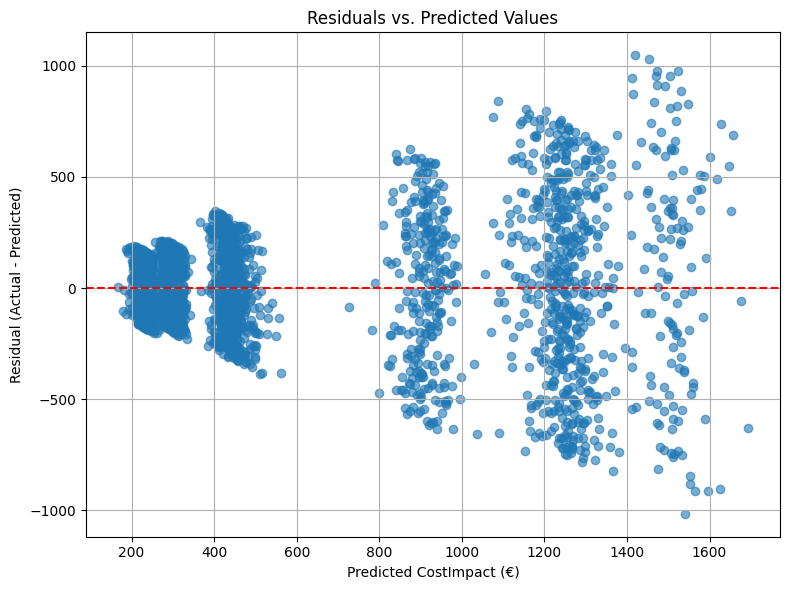

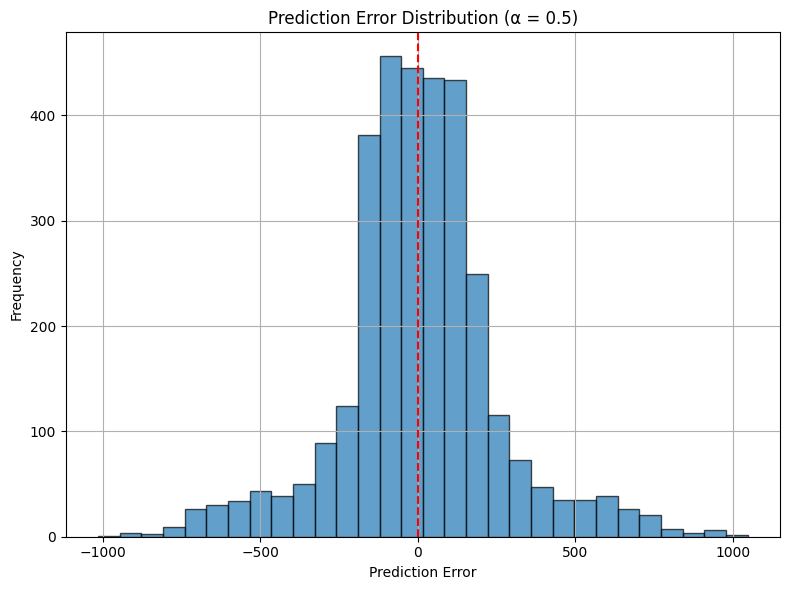

In [36]:
residuals = y_test - y_pred

# 1. Predicted vs Actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual CostImpact (€)")
plt.ylabel("Predicted CostImpact (€)")
plt.title("Quantile Prediction vs. Actual (α = 0.5)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Residuals vs Prediction
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted CostImpact (€)")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs. Predicted Values")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Error Histogram
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Prediction Error Distribution (α = 0.5)")
plt.grid(True)
plt.tight_layout()
plt.show()

This analysis shows which factors have the biggest impact on packaging costs. Understanding these key drivers helps businesses focus their cost reduction efforts on the most important areas.

In [37]:
# Get feature importance from your trained quantile model
importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": best_quantile_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Display
print("\n🔍 Feature Importance (Quantile Model):")
print(importance_df)


🔍 Feature Importance (Quantile Model):
                    Feature  Importance
3                    Weight        1602
0              SupplierName         961
4    ProposedUnitsPerCarton         951
10         IssueDescription         762
1               GarmentType         605
7                      Size         503
2                  Material         352
8                Collection         236
5     ProposedFoldingMethod         209
13         LayoutComplexity         195
16               LabelIssue         148
12                 IsWinter         135
9          PackagingQuality         127
15           SupplierIsTop5         116
11                 IsSummer         109
6            ProposedLayout          97
14        FoldingComplexity           0
17  PackagingQualityEncoded           0


#### 4.3 Saving

Finally, we save our trained cost prediction model so it can be used later to estimate the financial impact of potential packaging scenarios. This enables cost-aware decision making for future packaging choices.

In [ ]:
# Saving the model
model.save_model("catboost_model.cbm")

# Reading the model
# model = CatBoostClassifier()
# model.load_model("catboost_model.cbm")